In [1]:
path = './PokemonData'

In [2]:
from fastai.vision.all import *

/Users/radiohead/anaconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/radiohead/anaconda3/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /Users/radiohead/anaconda3/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <0FC5AB1D-5967-365A-8567-FFEDE40B4A09> /Users/radiohead/anaconda3/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [3]:
pokemon = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
) 

In [5]:
#for apple silicon pytorch error
!export PYTORCH_ENABLE_MPS_FALLBACK=1


/Users/radiohead/anaconda3/lib/python3.10/site-packages/torch/_tensor.py:1386: UserWarning: The operator 'aten::_linalg_solve_ex.result' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  ret = func(*args, **kwargs)


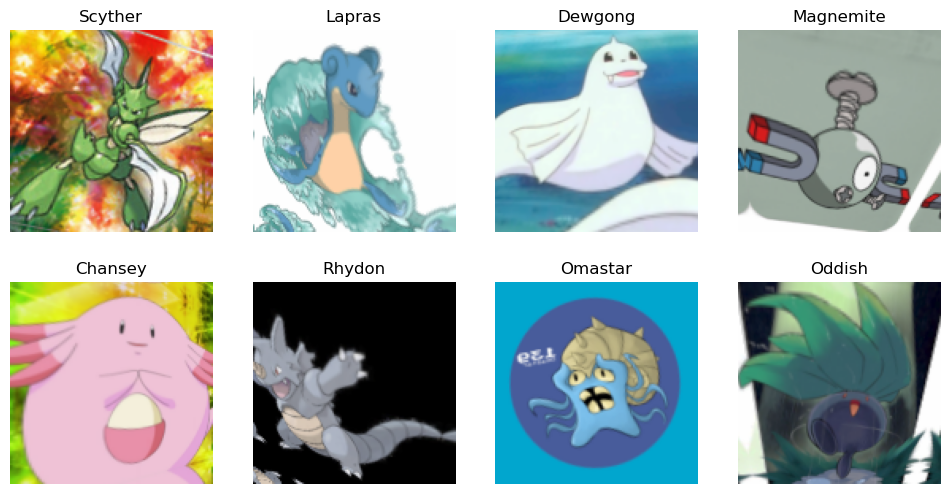

In [4]:
#making everything the same size n shape
pokemon = pokemon.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = pokemon.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=False)

In [5]:
# randomly resising and cropping the images to increase dataset
pokemon = pokemon.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)
dls = pokemon.dataloaders(path)

In [6]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

In [7]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,4.801910,2.073252,0.464809,01:18


epoch,train_loss,valid_loss,error_rate,time
0,2.202927,1.304734,0.279326,02:06
1,1.422630,0.690932,0.166422,01:59
2,0.870925,0.453266,0.112903,02:03
3,0.548068,0.375806,0.096774,02:07
4,0.369166,0.301312,0.079912,02:12
5,0.263059,0.281430,0.080645,02:16
6,0.187398,0.250248,0.062317,02:01
7,0.152300,0.238868,0.064516,02:09
8,0.124795,0.233420,0.065249,01:56
9,0.117547,0.230964,0.060117,01:54


In [9]:
# saving base model state before going on cos i dont wanna do this again and again
learn.export('model.pkl')

#### Training done, time to see the data

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(150,150))

#### yeah its mostly correct, like we can see from the really low error rates
##### huge number of data points -> really big matrix lol

In [28]:
# this is taking a heavy toll on my tiny m2 air lol
import gc
gc.collect() #this has ran too many times now..

11994

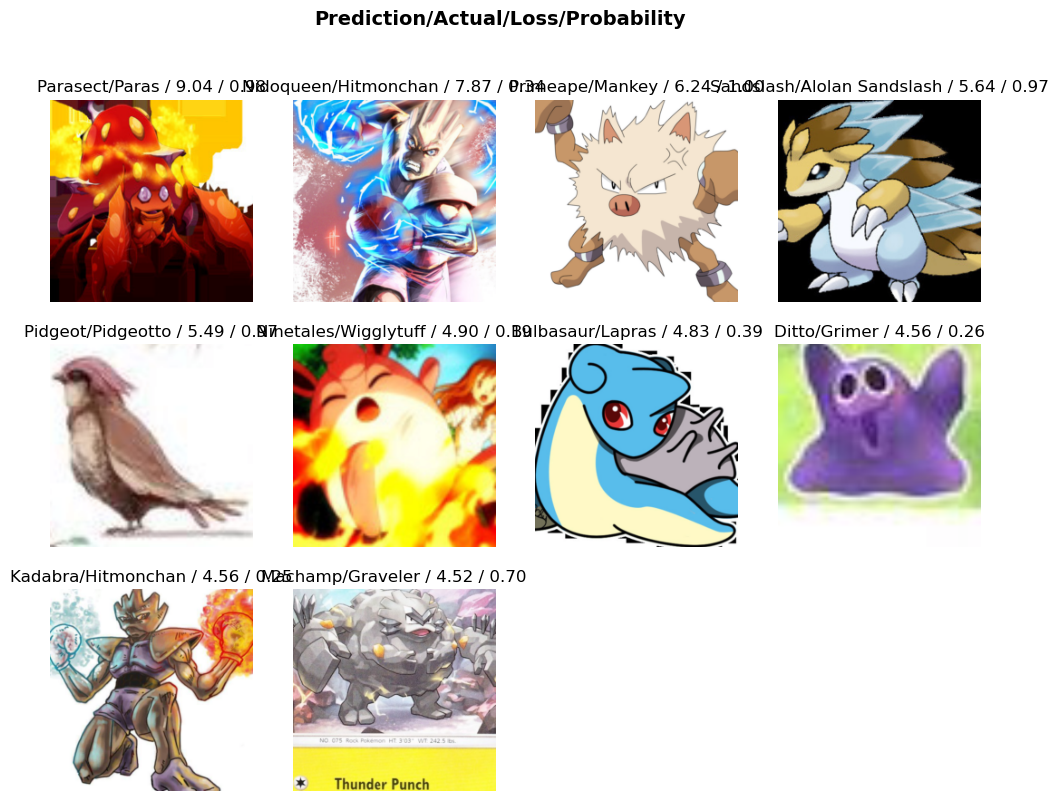

In [12]:
interp.plot_top_losses(10)

#### top 10 losses were in these pokemons, let's fix that

In [14]:
# manual labour
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
# didnt need this but would incase the dataset has misrepresentations
#for idx in cleaner.delete(): cleaner.fns[idx].unlink()

all seems good, continuing on..

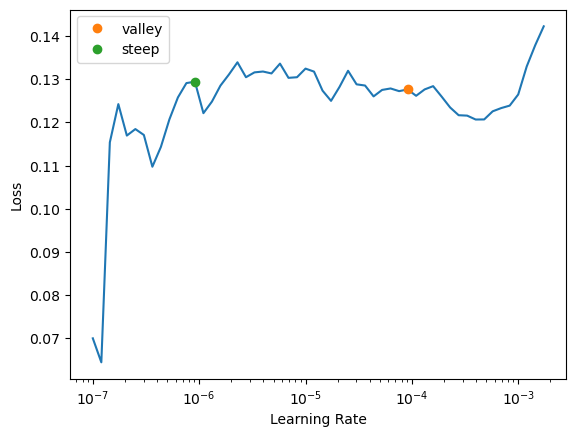

In [16]:
# lets see the learning rate vs loss graph:
lr_valley,lr_steep = learn.lr_find(suggest_funcs=(valley, steep))

*oof look at that slope, himalayas could never!!*

In [23]:
lr_steep

9.12010818865383e-07

In [21]:
learn.fit_one_cycle(2, lr_steep)

epoch,train_loss,valid_loss,error_rate,time
0,0.114082,0.227470,0.059384,01:43
1,0.099253,0.227620,0.058651,02:07


In [24]:
learn.unfreeze()

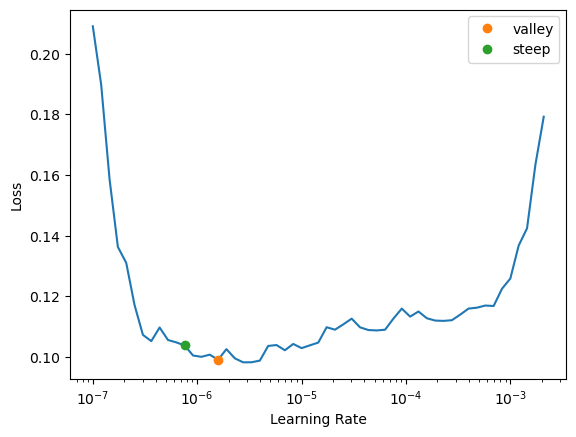

In [25]:
lr_valley, lr_steep = learn.lr_find(suggest_funcs=(valley, steep))

**valley learning rate has reached the minimum, we cannot get a lower loss than this atp, from the given dataset**
* one last iteration on this value before we save the model

In [26]:
learn.fit_one_cycle(3, lr_max=lr_valley)

epoch,train_loss,valid_loss,error_rate,time
0,0.101271,0.229018,0.058651,02:12
1,0.113533,0.228329,0.062317,01:53
2,0.110702,0.228433,0.061584,01:49


In [27]:
learn.export('model.pkl')